# Transfer Learning

## Learning Objectives
* See transfer learning in action

## Activity Instructions
1. Get my code running for your own system. This will require some tweaking as your filesystem structure will be different from my own. You'll also have to get the dataset downloaded and uploaded. 
2. Now that you have it running. How are you doing? Is the training and testing accuracy similar? Did you add in data augmentation in the transforms? Stay on this step until your training and testing accuracies are relatively similar.
3. If you reach step 3, awesome! What if you increase the size of the training dataset? What if you change the last layer to something else? How would you decide when to stop?

Extra credit. I'll give some extra credit if you make a hotdog/not hotdog app as seen on Silicon Valley :) This is outside of class of course. 

## Submission Instructions
**After completing the assignments, please upload a PDF output of this notebook.**

This is an individual assignment, but you may discuss your code with your neighbors.

## Model

Let's start with resnet18. You can read more about resnet18 from https://www.kaggle.com/datasets/pytorch/resnet18 and https://arxiv.org/pdf/1512.03385.pdf. Please take a moment and read a little about the model and its history.

In [10]:
import torch
import torchvision
from torchvision import datasets

from torchvision.models import resnet18, ResNet18_Weights
# here we load the pre-trained model
model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [11]:
# Check out the architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Dataset

We need a dataset of images. You will need to download the following dataset to your local computer: https://www.kaggle.com/datasets/thedatasith/hotdog-nothotdog?resource=download. Unzip the file and check out the structure of train/test.

Let's see how we can do with a small number of images of hotdogs and not hotdogs. I am storing my images on my server. Please store your images somewhere that works for your system. We are also going to want 10 images of test hotdogs and 10 images of test not hotdogs. You can change these numbers if you would like.

In [12]:
!mkdir -p $HOME/hotdog-nothotdog/train/hotdog
!mkdir -p $HOME/hotdog-nothotdog/train/nothotdog
!mkdir -p $HOME/hotdog-nothotdog/test/hotdog
!mkdir -p $HOME/hotdog-nothotdog/test/nothotdog

Here you just need to manually upload some images into those directories. Drag and drop away :)

After you do that, you'll want to define the locations in Python. For me that works as follows:

In [33]:
import os
home = os.getenv('HOME')
train_dir = f"{home}/hotdog-nothotdog/train/"
test_dir = f"{home}/hotdog-nothotdog/test/"
train_classa_dir = f"{train_dir}/hotdog"
train_classb_dir = f"{train_dir}/nothotdog"
test_classa_dir = f"{test_dir}/hotdog"
test_classb_dir = f"{test_dir}/nothotdog"

We need to load the dataset with torchvision.dataset and using the ImageFolder function. To do this, we'll need to define transforms that will format the load the data in a manner that works with our pre-trained model. For example, resnet18 accepts images of 64x64. We can define our own transforms, but PyTorch comes with associated transforms.

In [34]:
from torchvision.models import ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

In [79]:
import torchvision.transforms as transforms 

# define augmentation pipelines
train_tansform = transforms.Compose([
    # After running once, comment out this line and add in the following three lines.
    # Why does this make a difference?
    transforms.Resize((64, 64)), 
#    transforms.RandomResizedCrop(64),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_ransform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [81]:
train_dataset = datasets.ImageFolder(train_dir, train_tansform)
test_dataset = datasets.ImageFolder(test_dir, test_ransform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

We can check the sizes of our datasets and make sure it checks out:

In [82]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 100
Test dataset size: 23
Class names: ['hotdog', 'nothotdog']


Let's look at some of our images.

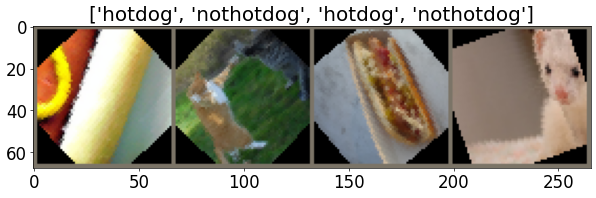

In [91]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

Now we can train our classifier. We need to replace the final layer with a new layer that has unfrozen weights.

In [92]:
params_not_frozen = []
for param in model.parameters():
    if param.requires_grad == True:
        params_not_frozen.append(param)
print("We have a lot of layers that are not frozen:",len(params_not_frozen))

We have a lot of layers that are not frozen: 2


In [93]:
# Make sure our parameters are frozen
for param in model.parameters():
    param.requires_grad = False

In [94]:
import torch.nn as nn
num_features = model.fc.in_features     #extract fc layers features
print('num_features',num_features)
model.fc = nn.Linear(num_features, 2) #(num_of_class == 2) - here is the magic. 

num_features 512


In [95]:
params_not_frozen = []
for param in model.parameters():
    if param.requires_grad == True:
        params_not_frozen.append(param)
print("Now only our last layer is not frozen:",len(params_not_frozen))

Now only our last layer is not frozen: 2


The value of two is from the bias. Here are the values:

In [96]:
params_not_frozen = []
for param in model.parameters():
    if param.requires_grad == True:
        params_not_frozen.append(param)
print(params_not_frozen)

[Parameter containing:
tensor([[-0.0277, -0.0267,  0.0390,  ...,  0.0436, -0.0381, -0.0308],
        [ 0.0040,  0.0070, -0.0211,  ...,  0.0423,  0.0068,  0.0272]],
       requires_grad=True), Parameter containing:
tensor([-0.0029,  0.0179], requires_grad=True)]


Let's do some training!

In [97]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 50   #(set no of epochs)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}%'.format(epoch, epoch_loss, epoch_acc))
    
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}%'.format(epoch, epoch_loss, epoch_acc))

Epoch 0 running
[Train #0] Loss: 0.9114 Acc: 45.0000%
[Test #0] Loss: 1.1795 Acc: 56.5217%
Epoch 1 running
[Train #1] Loss: 0.7046 Acc: 65.0000%
[Test #1] Loss: 1.0365 Acc: 52.1739%
Epoch 2 running
[Train #2] Loss: 0.4888 Acc: 76.0000%
[Test #2] Loss: 1.1337 Acc: 60.8696%
Epoch 3 running
[Train #3] Loss: 0.4841 Acc: 77.0000%
[Test #3] Loss: 1.1843 Acc: 56.5217%
Epoch 4 running
[Train #4] Loss: 0.6076 Acc: 73.0000%
[Test #4] Loss: 1.1347 Acc: 60.8696%
Epoch 5 running
[Train #5] Loss: 0.5619 Acc: 68.0000%
[Test #5] Loss: 0.8420 Acc: 65.2174%
Epoch 6 running
[Train #6] Loss: 0.4552 Acc: 82.0000%
[Test #6] Loss: 1.0570 Acc: 56.5217%
Epoch 7 running
[Train #7] Loss: 0.5108 Acc: 76.0000%
[Test #7] Loss: 1.0222 Acc: 56.5217%
Epoch 8 running
[Train #8] Loss: 0.4432 Acc: 83.0000%
[Test #8] Loss: 1.0513 Acc: 60.8696%
Epoch 9 running
[Train #9] Loss: 0.3635 Acc: 87.0000%
[Test #9] Loss: 1.5718 Acc: 60.8696%
Epoch 10 running
[Train #10] Loss: 0.3293 Acc: 84.0000%
[Test #10] Loss: 0.9451 Acc: 60.86